### Demonstration of Quantum Key Distribution

In this jupyter notebook we will demonstrate quantum key distribution using Qiskit. By now, you should be familiar with the basic steps of the protocol. Just to recall shortly, the ultimate goal is to gain a _shared secret_. In this case it will be a key shared between Bob and Alice, which can be used for encrypting messages. Only they will be able to know this secret.

In [1]:
import numpy as np
from numpy import pi

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister, execute
from qiskit.providers.aer import AerSimulator
from qiskit.tools import job_monitor

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

Alice will chose a basis and a bit randomly, Bob will pick a random basis. Hence, we define a random measurement function. In other words a two sided dice:

In [2]:
def random(circ, q, c):
    circ.reset(q) # we reset the qubit to |0>
    circ.h(q) # create superposition of |0> and |1>
    circ.measure(q,c) # measure: outcome will be 0 or 1, both 50% of the time
    circ.barrier() # this does not actually do anything

After this, Alice prepares the state for sending it to Bob

In [3]:
def prepare(circ, q, cbit, cbasis):
    circ.reset(q) # reset the qubit
    circ.x(q).c_if(cbit, 0) # apply x-gate (NOT) if the classical bit cbit has value 0
    circ.h(q) # hadamard-gate on q
    circ.s(q).c_if(cbasis, 0) # conditioned s-gate if cbit has value 0
    circ.barrier() # again, nothing happens here

Finally, Bob will measure in the basis, he chose randomly in the step before.


<div class="alert alert-block alert-success">
<b>Part 1</b>
    
ALthough, Bob does not remember how to implement the measurement process, he remembers, that the steps he has to take before measurement are the inverse of Alice's preparation process: $U_{Bob} = U_{Alice}^{\dagger} = (X H S)^{\dagger}$. Let's implement it
    
</div>

In [4]:
def measure(circ, q, cbit, cbasis):
    circ.sdg(q).c_if(cbasis, 0)
    circ.h(q)
    circ.x(q)
    circ.measure(q, cbit)

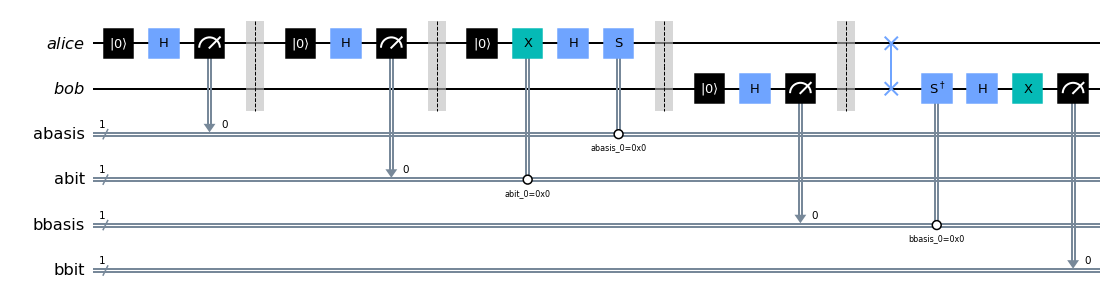

In [5]:
# STEP 1: We initialize our registers. We use two qubits and four classical bits

alice = QuantumRegister(1, 'alice')
bob = QuantumRegister(1, 'bob')
abasis = ClassicalRegister(1, 'abasis')
abit = ClassicalRegister(1, 'abit')
bbasis = ClassicalRegister(1, 'bbasis')
bbit = ClassicalRegister(1, 'bbit')
qkd = QuantumCircuit(alice, bob, abasis, abit, bbasis, bbit)

# STEP 2: Alice chooses a basis randomly
random(qkd, alice[0], abasis[0])

# STEP 3: Alice chooses whether she sends 0 or 1 by random
random(qkd, alice[0], abit[0])

# STEP 4: Alice prepares the state for sending it to Bob
prepare(qkd, alice[0], abit[0], abasis[0])

# STEP 5: Bob chooses the basis for measurement and 'receives' the qubit from Alice via quantum channel
random(qkd, bob[0], bbasis[0])
qkd.swap(alice[0], bob[0])

# STEP 6: Finally, Bob performs the measurement, depending, on
measure(qkd, bob[0], bbit[0], bbasis[0])

qkd.draw('mpl')

Now Alice and Bob repeat their measurement process for 1024 times. We will simulate this by running our quantum circuit 1024 times with the help of Aer backend. Then, we will be extracting the bitstrings representing Alice and Bob's respective choices of basis (0 or 1 base) and their respective measurements.

In [6]:
aer_sim = Aer.get_backend('aer_simulator') # we load the simulator backend

key_length = 1024 # let's create a 1024 bits long key

# these strings are gonna be the bitstrings representing Alice's and Bob's basis choices as well as their raw keys
abasis = "" 
abit = ""
bbasis = ""
bbit = ""

# run the algorithm 1024 times
for i in range(0, int(key_length)):
    results = aer_sim.run(qkd, shots=1).result()
    counts = results.get_counts()
    res = list(counts.keys())[0]
    abasis += res[6]
    abit += res[4]
    bbasis += res[2]
    bbit += res[0]


For example, Alice recovered this bitstring:

In [7]:
abit

'011000100100101110101010111111100111101010000011111010000111100100110001101001000101100001011110111001001101000010111110101001000011000100110100111001101010000001010110001011010100100000010000101001101000010100100011101101000111011111101011110111111100101011101111001100101011001011011000100110010111100000000011011110101010001000101010111110000000010100100100011010011000011100010011110100100000101111111011000010001001011110110100100011000110101010010001010011010100001110110000011000101101100111010111101011001100100001100110101000000000010101111011000001111101100000100101111000000000010010011010010001100111101001110010000110010100101111011110110111101111111110010101111100101110101001101111011101010100000101110010111101010111000111000101101110010100111000000100010010100111011101011100110011011001011000011001100011011101100010001110011111010000000000001100010101011100011101001101000100010110010101010010101001001001100101000100110001010100111111011001111010001001010001111111011111000110101

And Bob recovered this one:

In [8]:
bbit

'101111100100101110101001011110101110101000001111111100000111100100000000101001010000000001011111101001001100000011111100101101100011001000111000111001101001010101010101001111010000010000010100111011100010011110110111111101011101001011101111110011111110000110011011101111100011000111010000000000010011100101000011111110101010000100001001011110000000000111100101011011011100001000101011010000110000111101111010100111101001010111101100001000110110101111000000010111010100000100010000011000101111111111000101101101011100000001100111101000000110001000011110000001011101100111010101111101000000000010011110100001100100001001110000100010100000101111001011110111101110111100010101110010101001001101101101110101010000000000100110001011110110110111001101101110011100110010000100110010000001111111110000100001010100111000001101110001111111110010111110011111010100000100001101000101011100001000001111010101000110011100110111000001001000101001011100111000000101101001011101010110100001010001011111001111101110111

In [9]:
abit == bbit

False

Note that both bitstrings are **not** the same!

Next, we want to dwelve into the postprocessing. Of course, Alice and Bob sometimes accidentally pick a different basis and might thus measure a different outcome. This is the reason why at this point their keys do not match. Therefore, Bob and Alice have to compare their choices of basis and ignore all measurements in which they did not choose the same basis.

This process is called **key sifting** and is essential for the implementation of BB84. Without it, the whole protocol fails. 

<div class="alert alert-block alert-success">
<b>Part 2</b>
    
Now, we will implement the key sifting. Basically, iterate over every single measurement and discard every bit for which the basis that Alice and Bob chose independently does not match. The function 'sifted_key_positions' should return a list of all indeces of usable measurements.
    
</div>

In [10]:
def sifted_key_positions(abasis, bbasis):
    pos = []
    for i in range(0, len(abasis)):
        if abasis[i] == bbasis[i]:
                pos.append(i)
    return pos

In [11]:
# now let's check whether Bob's key matches Alice's!

sifted_key_alice = "".join([abit[j] for j in sifted_key_positions(abasis, bbasis)])
sifted_key_bob = "".join([bbit[j] for j in sifted_key_positions(abasis, bbasis)])

sifted_key_alice == sifted_key_bob

True

In case this returns 'True': **BB84 was successfully implemented!** 

Unfortunately, _real life_ does not work like this. We will now introduce some noise to the quantum algorithm. Just recall for a moment, that every quantum mechanical system is prone to noise. Let's run the same ircuit but now in a _real_ machine.

In [12]:
backend = provider.get_backend('ibmq_santiago')
aer_sim = AerSimulator.from_backend(backend)

key_length = 1024

abasis = ""
abit = ""
bbasis = ""
bbit = ""randomly

for i in range(0, int(key_length)):
    results = aer_sim.run(qkd, shots=1).result()
    counts = results.get_counts()
    res = list(counts.keys())[0]
    abasis += res[6]
    abit += res[4]
    bbasis += res[2]
    bbit += res[0]
    
n_sifted_key_alice = "".join([abit[j] for j in sifted_key_positions(abasis, bbasis)])
n_sifted_key_bob = "".join([bbit[j] for j in sifted_key_positions(abasis, bbasis)])

print(n_sifted_key_alice == n_sifted_key_bob)

False


Darn! Alice and Bob do not have the same key.

But how much exactly do they differ?

<div class="alert alert-block alert-success">
<b>Part 3</b>
    
We will calculate the quantum bit error rate (QBER). It is defined as the rate of errors in the key. You can calculate it by counting the number of errors and then dividing by the key length.
    
</div>

In [13]:
def qber(key_a, key_b):
    errors = 0
    n = len(key_a)
    for i in range(n):
        if(key_a[i] != key_b[i]):
            errors += 1
    return errors/n

qber(n_sifted_key_alice, n_sifted_key_bob)

0.01818181818181818

In our case, the quantum bit error rate should be a little less than 7%. A complete implementation of the BB84 would also include an error correction algorithm. We're not gonna go there during this lecture. You don't have to worry about it _for now_. Instead, since the whole point of quantum key distribution is to establish security, let's check what happens to our quantum system, in case there is an eavesdropper, Eve, trying to spy on Alice and Bob's quantum _conversation_. We modify our quantum circuit a little:

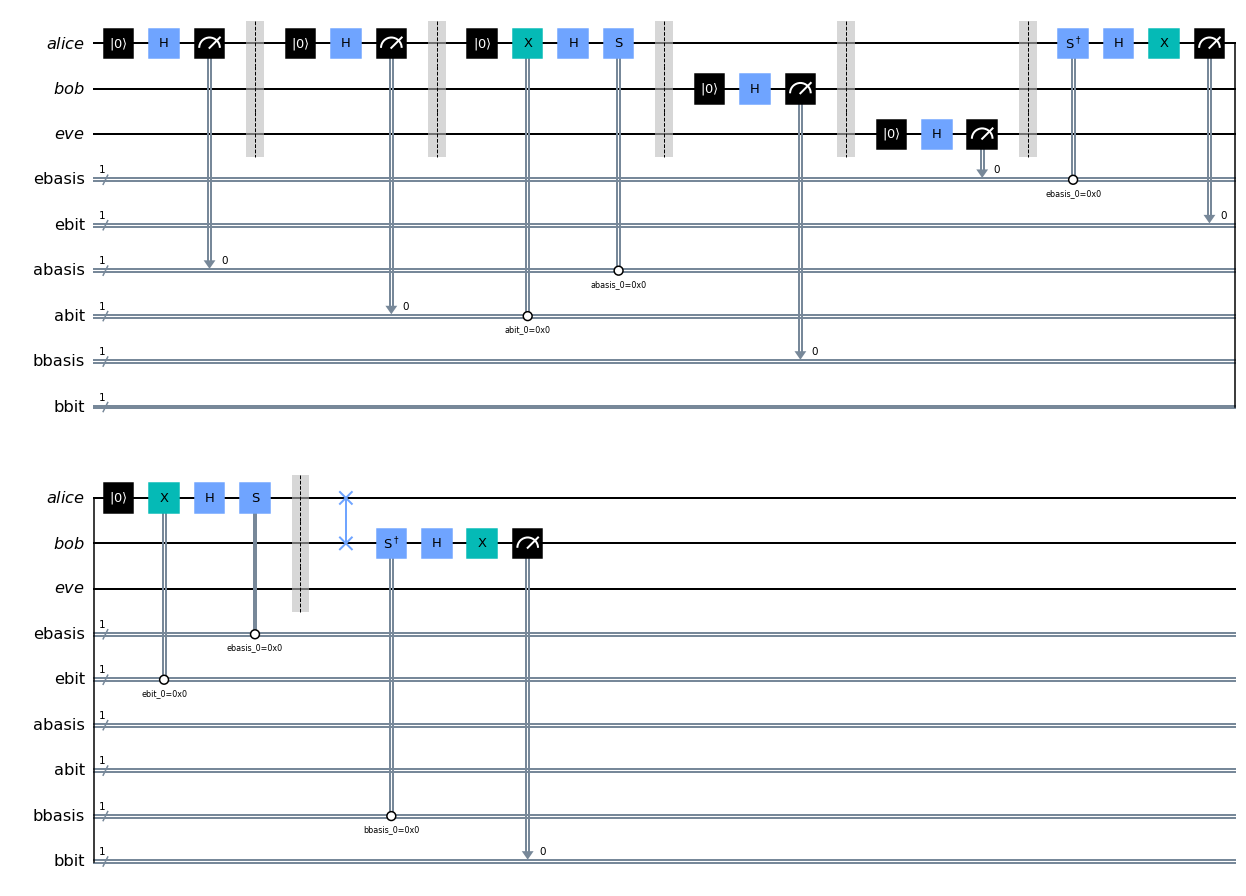

In [14]:
def eavesdropping(circ, q, qbasis, cbit, cbasis):
    random(qkd, qbasis, cbasis) # Eve will chose a basis for measuring the qubit randomly
    measure(qkd, q, cbit, cbasis) # next she measures it
    prepare(qkd, q, cbit, cbasis) # and then she prepares a new qubit so Bob will not be suspicious of her actions
    

# STEP 1: We initialize our registers. We use two qubits and four classical bits for Alice and Bob
# Add a qubit and two classical bits for Eve

alice = QuantumRegister(1, 'alice')
bob = QuantumRegister(1, 'bob')
eve = QuantumRegister(1, 'eve')

abasis = ClassicalRegister(1, 'abasis')
abit = ClassicalRegister(1, 'abit')
bbasis = ClassicalRegister(1, 'bbasis')
bbit = ClassicalRegister(1, 'bbit')
ebasis = ClassicalRegister(1, 'ebasis')
ebit = ClassicalRegister(1, 'ebit')

qkd = QuantumCircuit(alice, bob, eve, ebasis, ebit, abasis, abit, bbasis, bbit)

# STEP 2: Alice chooses a basis randomly
random(qkd, alice[0], abasis[0])

# STEP 3: Alice chooses whether she sends 0 or 1 by random
random(qkd, alice[0], abit[0])

# STEP 4: Alice prepares the state for sending it to Bob
prepare(qkd, alice[0], abit[0], abasis[0])

# STEP 5: Bob chooses the basis for measurement and 'receives' the qubit from Alice via quantum channel
random(qkd, bob[0], bbasis[0])

# STEP 5.5: Eve tries to get as much information as possible by intercepting every qubit, measuring it in a random basis
# and preparing a new qubit for Bob
eavesdropping(qkd, alice[0], eve[0], ebit[0], ebasis[0])

qkd.swap(alice[0], bob[0])

# STEP 6: Finally, Bob performs the measurement, depending, on
measure(qkd, bob[0], bbit[0], bbasis[0])

qkd.draw('mpl')

Great! Eve will read information from the quantum channel, but what happens now? Let's check it out. But for the sake of demonstration, we will remove any other noise, thus simulating an ideal system again.

In [15]:
aer_sim = Aer.get_backend('aer_simulator') 

key_length = 2**11

abasis = ""
abit = ""
bbasis = ""
bbit = ""
ebasis = ""
ebit = ""

for i in range(0, int(key_length)):
    results = execute(qkd, aer_sim, shots=1).result()
    counts = results.get_counts()
    res = list(counts.keys())[0]
    ebasis += res[10]
    ebit += res[8]
    abasis += res[6]
    abit += res[4]
    bbasis += res[2]
    bbit += res[0]

print(counts)

{'1 1 1 1 1 0': 1}


In [16]:
ne_sifted_key_alice = "".join([abit[j] for j in sifted_key_positions(abasis, bbasis)])
ne_sifted_key_bob = "".join([bbit[j] for j in sifted_key_positions(abasis, bbasis)])

# Eve will have to stick with the basis choices of Alice and Bob
ne_sifted_key_eve = "".join([ebit[j] for j in sifted_key_positions(abasis, bbasis)])

print(f"Quantum bit error rate of Bob: {qber(ne_sifted_key_alice, ne_sifted_key_bob)*100:.2f}%")
print(f"Amount of information Eve was able to snoop on: {(1-qber(ne_sifted_key_alice, ne_sifted_key_eve))*100:.2f}%")

Quantum bit error rate of Bob: 26.30%
Amount of information Eve was able to snoop on: 73.90%


We observe that Eve was able to read a significant amount of the key! Actually she has about the same level of knowledge of Alice's numbers as Bob. This means a secure post-processing cannout be done. Alice and Bob should not use this quantum key! Fortunately, we also observe, that Bob's quantum bit error rate has increased to about 25%. This is another advantage of quantum key distribution: attacks can be noticed by Alice and Bob.